In [90]:
%conda install matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /Users/matthew/anaconda3/envs/Machingearning310

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-3.8.0           |  py310hecd8cb5_0           9 KB
    ------------------------------------------------------------
                                           Total:           9 KB

The following NEW packages will be INSTALLED:

  matplotlib         pkgs/main/osx-64::matplotlib-3.8.0-py310hecd8cb5_0 



                                                                                
Pre

In [91]:
import pandas as pd
import sklearn
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, PowerTransformer, StandardScaler
from sklearn.neural_network import MLPRegressor
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
# train = data.loc[:train.shape[0] - 1,:]
# test = data.loc[train.shape[0]:,:] 

Run time adjustment

In [8]:
train.loc[train['id'] == 1336,'runtime'] = 130
train.loc[train['id'] == 2303,'runtime'] = 80 
train.loc[train['id'] == 391,'runtime'] = 96
train.loc[train['id'] == 592,'runtime'] = 90
train.loc[train['id'] == 925,'runtime'] = 86
train.loc[train['id'] == 978,'runtime'] = 93
train.loc[train['id'] == 1256,'runtime'] = 92 
train.loc[train['id'] == 1542,'runtime'] = 93 
train.loc[train['id'] == 1875,'runtime'] = 93 
train.loc[train['id'] == 2151,'runtime'] = 108
train.loc[train['id'] == 2499,'runtime'] = 86 
train.loc[train['id'] == 2646,'runtime'] = 98 
train.loc[train['id'] == 2786,'runtime'] = 111
train.loc[train['id'] == 2866,'runtime'] = 96 
test.loc[test['id'] == 3244,'runtime'] = 93 
test.loc[test['id'] == 4490,'runtime'] = 90 
test.loc[test['id'] == 4633,'runtime'] = 108
test.loc[test['id'] == 6818,'runtime'] = 90 
test.loc[test['id'] == 4074,'runtime'] = 103
test.loc[test['id'] == 4222,'runtime'] = 91 
test.loc[test['id'] == 4431,'runtime'] = 96 
test.loc[test['id'] == 5520,'runtime'] = 86 
test.loc[test['id'] == 5845,'runtime'] = 83 
test.loc[test['id'] == 5849,'runtime'] = 140
test.loc[test['id'] == 6210,'runtime'] = 104
test.loc[test['id'] == 6804,'runtime'] = 140
test.loc[test['id'] == 7321,'runtime'] = 87 

Additional Features

In [9]:
train_add = pd.read_csv('TrainAdditionalFeatures.csv')
test_add = pd.read_csv('TestAdditionalFeatures.csv')

train = pd.merge(train, train_add, how='left', on=['imdb_id'])
test = pd.merge(test, test_add, how='left', on=['imdb_id'])

In [10]:
df = pd.concat([train, test]).set_index("id")

In [11]:
df.loc[df.index == 90,'budget'] = 30000000
df.loc[df.index == 118,'budget'] = 60000000
df.loc[df.index == 149,'budget'] = 18000000
df.loc[df.index == 464,'budget'] = 20000000
df.loc[df.index == 819,'budget'] = 90000000
df.loc[df.index == 1112,'budget'] = 6000000
df.loc[df.index == 1131,'budget'] = 4300000
df.loc[df.index == 1359,'budget'] = 10000000
df.loc[df.index == 1570,'budget'] = 15800000
df.loc[df.index == 1714,'budget'] = 46000000
df.loc[df.index == 1865,'budget'] = 80000000
df.loc[df.index == 2602,'budget'] = 31000000

In [12]:
df = df.drop(["poster_path", "original_title"], axis=1)

In [13]:
df["log_revenue"] = np.log1p(df["revenue"])
df["log_budget"] = np.log1p(df["budget"])

In [14]:
df['isbelongs_to_collectionNA'] = 1
df.loc[pd.isnull(df['belongs_to_collection']) ,"isbelongs_to_collectionNA"] = 0

In [15]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

for col in dict_columns:
       df[col]=df[col].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )

In [16]:
dfdic_feature = {}

In [88]:
#
def count_word_list(series):
    len_max = series.apply(len).max() 
    tmp = series.map(lambda x: x+["nashi"]*(len_max-len(x)))
    print(tmp)
    
    word_set = set(sum(list(series.values), []))
    for n in range(len_max):
        word_dfn = pd.get_dummies(tmp.apply(lambda x: x[n]))
        word_dfn = word_dfn.reindex(word_set, axis=1).fillna(0).astype(int)
        if n==0:
            word_df = word_dfn
        else:
            word_df = word_df + word_dfn
    
    return word_df

In [31]:
#
def select_top_n(df, topn=9999, nmin=2):
    n_word = (df.loc[train["id"]]>0).sum().sort_values(ascending=False)
    smallmin = n_word[n_word<nmin].index
    smalln = n_word.iloc[topn+1:].index
    small = set(smallmin) | set(smalln)
    small = list(small)
    df["small"] = df[small].sum(axis=1)
    
    return df.drop(small, axis=1)

In [19]:
df["genre_names"] = df["genres"].apply(lambda x : [ i["name"] for i in x])
df['num_genres'] = df['genres'].apply(lambda x: len(x) if x != {} else 0)

In [89]:
dfdic_feature["genre"] = count_word_list(df["genre_names"])
dfdic_feature["genre"] = dfdic_feature["genre"].drop("TV Movie", axis=1)
dfdic_feature["genre"].head()

id
1       [Comedy, nashi, nashi, nashi, nashi, nashi, na...
2       [Comedy, Drama, Family, Romance, nashi, nashi,...
3       [Drama, nashi, nashi, nashi, nashi, nashi, nas...
4       [Thriller, Drama, nashi, nashi, nashi, nashi, ...
5       [Action, Thriller, nashi, nashi, nashi, nashi,...
                              ...                        
7394    [Thriller, nashi, nashi, nashi, nashi, nashi, ...
7395    [Action, Adventure, Comedy, Thriller, nashi, n...
7396    [Drama, nashi, nashi, nashi, nashi, nashi, nas...
7397    [Horror, Thriller, nashi, nashi, nashi, nashi,...
7398    [Drama, nashi, nashi, nashi, nashi, nashi, nas...
Name: genre_names, Length: 7398, dtype: object


,Animation,Family,Foreign,Fantasy,Adventure,Thriller,Romance,Crime,Science Fiction,Mystery,War,Horror,Drama,Documentary,Western,Action,Music,Comedy,History
id,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [21]:
df["original_language"] = df["original_language"].astype("category")

In [22]:
df['isOriginalLanguageEng'] = 0 
df.loc[ df['original_language'] == "en" ,"isOriginalLanguageEng"] = 1

In [23]:
dfdic_feature["original_language"] = pd.get_dummies(df["original_language"])

dfdic_feature["original_language"].head()

,af,ar,bm,bn,ca,cn,cs,da,de,el,...,sr,sv,ta,te,th,tr,ur,vi,xx,zh
id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['original_language'] = le.fit_transform(df['original_language'])

In [25]:
df["production_names"] = df["production_companies"].apply(lambda x : [ i["name"] for i in x])
tmp = count_word_list(df["production_names"])

In [32]:
dfdic_feature["production_companies"] = select_top_n(tmp, topn=9,nmin=2)
dfdic_feature["production_companies"].head()

/var/folders/1y/f0q74wq572s6z2d3y05_8gh00000gn/T/ipykernel_6515/3045027195.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["small"] = df[small].sum(axis=1)


,Paramount Pictures,Columbia Pictures,Touchstone Pictures,Warner Bros.,Columbia Pictures Corporation,Metro-Goldwyn-Mayer (MGM),Universal Pictures,New Line Cinema,Twentieth Century Fox Film Corporation,Walt Disney Pictures,small
id,,,,,,,,,,,
1,1,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0


In [33]:
df["country_names"] = df["production_countries"].apply(lambda x : [ i["name"] for i in x])
df_country = count_word_list(df["country_names"])

In [34]:
df_country = (df_country.T/df_country.sum(axis=1)).T.fillna(0)

In [35]:
dfdic_feature["production_countries"] = select_top_n(df_country, topn=10,nmin=2)
dfdic_feature["production_countries"].head()

,Japan,Canada,Germany,United States of America,France,Spain,United Kingdom,India,Russia,Italy,Australia,small
id,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
df.loc[3829, "release_date"] = "5/1/00"

In [37]:
df["release_year"] = pd.to_datetime(df["release_date"]).dt.year.astype(int)
df.loc[df["release_year"]>2020, "release_year"] = df.loc[df["release_year"]>2020, "release_year"]-100

df["release_month"] = pd.to_datetime(df["release_date"]).dt.month.astype(int)
df["release_day"] = pd.to_datetime(df["release_date"]).dt.day.astype(int)
df["release_date"] = df.apply(lambda s: datetime.datetime(
    year=s["release_year"],month=s["release_month"],day=s["release_day"]), axis=1)
df["release_dayofyear"] = df["release_date"].dt.dayofyear
df["release_dayofweek"] = df["release_date"].dt.dayofweek

/var/folders/1y/f0q74wq572s6z2d3y05_8gh00000gn/T/ipykernel_6515/2767491132.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["release_year"] = pd.to_datetime(df["release_date"]).dt.year.astype(int)
/var/folders/1y/f0q74wq572s6z2d3y05_8gh00000gn/T/ipykernel_6515/2767491132.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["release_month"] = pd.to_datetime(df["release_date"]).dt.month.astype(int)
/var/folders/1y/f0q74wq572s6z2d3y05_8gh00000gn/T/ipykernel_6515/2767491132.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["release_day"] = pd.to_datetime(df["releas

In [38]:
df['has_homepage'] = 1
df.loc[ pd.isnull(df['homepage']),'has_homepage'] = 0

In [39]:
df['num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)

In [40]:
df['overview_word_count'] = df['overview'].apply(lambda x: len(str(x).split()))

df['overview_char_count'] = df['overview'].apply(lambda x: len(str(x)))

In [41]:
#単語数
df['tagline_word_count'] = df['tagline'].apply(lambda x: len(str(x).split()))
#文字数
df['tagline_char_count'] = df['tagline'].apply(lambda x: len(str(x)))
#taglineがあるかどうか
df['isTaglineNA'] = 0
df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

In [42]:
#単語数
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
#文字数
df['title_char_count'] = df['title'].apply(lambda x: len(str(x)))

In [43]:
df['num_cast'] = df['cast'].apply(len)  # 人数

In [44]:
list_of_cast_genders = list(df['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)

df['genders_0_cast'] = df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df['genders_1_cast'] = df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df['genders_2_cast'] = df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
# 欠損は平均で埋める
df[['genders_0_cast', 'genders_1_cast']] = df[['genders_0_cast', 'genders_1_cast']].fillna(df[['genders_0_cast', 'genders_1_cast']].mean())

In [45]:
df['num_crew'] = df['crew'].apply(len)  # 人数

In [46]:
department_count = pd.Series(Counter([job for lst in df["crew"].apply(lambda x : [ i["department"] for i in x]).values for job in lst]))
department_count.sort_values(ascending=False)


Production           38927
Sound                22497
Art                  19870
Crew                 17529
Writing              16329
Costume & Make-Up    15223
Camera               13229
Directing            12245
Editing              11135
Visual Effects        9472
Lighting              3129
Actors                   5
dtype: int64

In [47]:
job_count = pd.Series(Counter([job for lst in df["crew"].apply(lambda x : [ i["job"] for i in x]).values for job in lst]))
job_count.sort_values(ascending=False).head(30)

Producer                     14670
Executive Producer            8533
Director                      8051
Screenplay                    7381
Editor                        7054
Casting                       6055
Director of Photography       5611
Original Music Composer       4768
Art Direction                 4637
Production Design             4027
Costume Design                3876
Writer                        3870
Set Decoration                3261
Makeup Artist                 2710
Sound Re-Recording Mixer      2257
Script Supervisor             2230
Camera Operator               2207
Animation                     2044
Visual Effects Supervisor     2001
Hairstylist                   1939
Sound Effects Editor          1855
Still Photographer            1701
Visual Effects Producer       1695
Music Editor                  1669
Dialogue Editor               1597
Co-Producer                   1589
Music                         1583
Stunts                        1492
Stunt Coordinator   

In [51]:
df_crew = { idx : pd.DataFrame([ [crew["department"], crew["job"], crew["name"]] 
                        for crew in x], columns=["department", "job", "name"]) 
    for idx, x in df["crew"].items() }

In [52]:
df_crew = pd.concat(df_crew)
df_crew.head()

department                       job           name
1 0   Directing  First Assistant Director  Kelly Cantley
  1   Directing                  Director     Steve Pink
  2     Writing                    Writer     Josh Heald
  3     Writing                Characters     Josh Heald
  4  Production                  Producer   Andrew Panay

In [53]:
def select_job(list_dict, key, value):
    return [ dic["name"] for dic in list_dict if dic[key]==value]

In [54]:
# 各部署の人数
for department in department_count.index:
    df['dep_{}_num'.format(department)] = df["crew"].apply(select_job, key="department", value=department).apply(len) 

In [55]:
df_crewname = pd.DataFrame([], index=df.index)
for job in ["Producer", "Director", "Screenplay", "Casting", "Original Music Composer","Writer"]:
    col = 'job_{}_list'.format(job)
    df[col] = df["crew"].apply(select_job, key="job", value=job)

    top_list = [m[0] for m in Counter([i for j in df[col] for i in j]).most_common(15)]
    for i in top_list:
        df_crewname['{}_{}'.format(job,i)] = df[col].apply(lambda x: i in x)

In [56]:
for job in ["Sound", "Art", "Costume & Make-Up", "Camera", "Visual Effects"]:
    col = 'department_{}_list'.format(job)
    df[col] = df["crew"].apply(select_job, key="department", value=job)

    top_list = [m[0] for m in Counter([i for j in df[col] for i in j]).most_common(15)]
    for i in top_list:
        df_crewname['{}_{}'.format(job,i)] = df[col].apply(lambda x: i in x)

/var/folders/1y/f0q74wq572s6z2d3y05_8gh00000gn/T/ipykernel_6515/2197081515.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_crewname['{}_{}'.format(job,i)] = df[col].apply(lambda x: i in x)
/var/folders/1y/f0q74wq572s6z2d3y05_8gh00000gn/T/ipykernel_6515/2197081515.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_crewname['{}_{}'.format(job,i)] = df[col].apply(lambda x: i in x)
/var/folders/1y/f0q74wq572s6z2d3y05_8gh00000gn/T/ipykernel_6515/2197081515.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is 

In [57]:
df.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'imdb_id',
       'original_language', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'popularity2', 'rating', 'totalVotes', 'log_revenue', 'log_budget',
       'isbelongs_to_collectionNA', 'genre_names', 'num_genres',
       'isOriginalLanguageEng', 'production_names', 'country_names',
       'release_year', 'release_month', 'release_day', 'release_dayofyear',
       'release_dayofweek', 'has_homepage', 'num_Keywords',
       'overview_word_count', 'overview_char_count', 'tagline_word_count',
       'tagline_char_count', 'isTaglineNA', 'title_word_count',
       'title_char_count', 'num_cast', 'genders_0_cast', 'genders_1_cast',
       'genders_2_cast', 'num_crew', 'dep_Directing_num', 'dep_Writing_num',
       'dep_Production_num', 'dep_Sound_num', 'dep_Camera

In [58]:
df['job_Animation_num'] = df["crew"].apply(select_job, key="job", value="Animation").apply(len)

In [59]:
# crew gender
df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
# 欠損は平均で埋める
df[['genders_0_crew', 'genders_1_crew','genders_2_crew']] = df[['genders_0_crew', 'genders_1_crew','genders_2_crew']].fillna(df[['genders_0_crew', 'genders_1_crew','genders_2_crew']].mean())

In [60]:
df['budget_runtime_ratio'] = df['budget']/df['runtime']

In [61]:
df['budget_popularity_ratio'] = df['budget']/df['popularity']

In [62]:
df['budget_popularity2_ratio'] = df['budget']/df['popularity2']
df['budget_year_ratio'] = df['budget']/df['release_year']
df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))

In [63]:
df["collection_name"] = df["belongs_to_collection"].apply(lambda x : x[0]["name"] if len(x)>0 else 0)
le.fit(list(df['collection_name'].fillna('')))
df['collection_name'] = le.transform(df['collection_name'].fillna('').astype(str))

In [64]:
df['mean_pop1_bud'] = df.groupby('popularity')['budget'].transform('mean')
df['mean_pop2_bud'] = df.groupby('popularity2')['budget'].transform('mean')
df['mean_year_bud'] = df.groupby('release_year')['budget'].transform('mean')
df['mean_pop1_rate'] = df.groupby('popularity')['rating'].transform('mean')
df['mean_pop2_rate'] = df.groupby('popularity2')['rating'].transform('mean')
df['mean_rate_tV'] = df.groupby('rating')['totalVotes'].transform('mean')

In [65]:
df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_year")["runtime"].transform('mean')
df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_year")["popularity"].transform('mean')
df['budget_to_mean_year'] = df['budget'] / df.groupby("release_year")["budget"].transform('mean')

In [66]:
df_features = pd.concat(dfdic_feature, axis=1)

In [67]:
df_use = df[['num_cast', 'genders_0_cast','runtime_to_mean_year','budget_to_mean_year',"log_budget",
       'genders_1_cast','genders_2_cast', 'num_crew', 'genders_0_crew', 'genders_1_crew','genders_2_crew',
             "tagline_word_count","overview_word_count","title_word_count","has_homepage",
            'popularity','runtime','release_year', 'release_month','release_dayofweek',"num_genres"
            ,"popularity2","rating","totalVotes",'isOriginalLanguageEng',
             'budget_runtime_ratio','budget_popularity_ratio','budget_year_ratio','budget_popularity2_ratio',
            'production_countries_count','production_companies_count','mean_pop1_bud','mean_pop2_bud','mean_year_bud','mean_pop1_rate',
            'mean_pop2_rate','mean_rate_tV',
           'dep_Directing_num', 'dep_Writing_num', 'dep_Production_num',
       'dep_Sound_num', 'dep_Camera_num', 'dep_Editing_num', 'dep_Art_num',
       'dep_Costume & Make-Up_num', 'dep_Crew_num', 'dep_Lighting_num',
       'dep_Visual Effects_num', 'dep_Actors_num', 'job_Animation_num' ]]

In [68]:
df_use = pd.concat([df_use, df_features], axis=1)

In [69]:
df_use.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_use.columns]

In [70]:
trainX = df_use.iloc[:train.shape[0],:].reset_index(drop=True)
test_X = df_use.iloc[train.shape[0]:,:].reset_index(drop=True)
trainy = np.log1p(train["revenue"])

In [71]:
X_train, X_test, y_train, y_test = train_test_split(trainX,trainy,test_size=0.3,random_state=100)

In [72]:
%conda install xgboost lightgbm catboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /Users/matthew/anaconda3/envs/Machingearning310

  added / updated specs:
    - catboost
    - lightgbm
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB
    boost-cpp-1.82.0           |       ha357a0b_2          12 KB
    cairo-1.16.0               |       h3ce6f7e_5        1013 KB
    catboost-1.2               |  py310hecd8cb5_0        20.5 MB
    contourpy-1.2.0            |  py310ha357a0b_0         242 KB
    expat-2.5.0                |       hcec6c5f_0  

In [73]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
xgbmodel = xgb.XGBRegressor(max_depth=6, 
                            min_child_weight=3,
                            alpha = 0.5,
                            learning_rate=0.05, 
                            n_estimators=150, 
                            objective='reg:linear', 
                            gamma=0.01,  
                            silent=1,
                            subsample=0.8, 
                            colsample_bytree=0.8)

In [74]:
xgbmodel.fit(X_train, y_train)

/Users/matthew/anaconda3/envs/Machingearning310/lib/python3.10/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/matthew/anaconda3/envs/Machingearning310/lib/python3.10/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/matthew/anaconda3/envs/Machingearning310/lib/python3.10/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/matthew/anaconda3/envs/Machingearning310/lib/python3.10/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

[15:08:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', ...)

In [75]:
pred_xgb = xgbmodel.predict(test_X)
test_id = test["id"]
pred_xgb = pd.DataFrame(np.expm1(pred_xgb),columns=["revenue"])
pred_xgb

/Users/matthew/anaconda3/envs/Machingearning310/lib/python3.10/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/matthew/anaconda3/envs/Machingearning310/lib/python3.10/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/matthew/anaconda3/envs/Machingearning310/lib/python3.10/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/matthew/anaconda3/envs/Machingearning310/lib/python3.10/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

,revenue
0,8.078790e+06
1,3.973314e+06
2,7.556684e+06
3,6.623286e+06
4,3.253486e+05
...,...
4393,3.909333e+07
4394,2.984804e+07
4395,1.617189e+07
4396,3.194864e+07


In [76]:
sub=pd.concat([test_id, pred_xgb],axis=1)
sub.to_csv('TMDB_xgb.csv',index=False)

In [77]:
lgbmodel = lgb.LGBMRegressor(n_estimators=150, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=30, 
                             min_child_samples=30,
                             learning_rate=0.05,
                             boosting = 'gbdt',
                             min_data_in_leaf= 15,
                             feature_fraction = 0.9,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2, 
                             subsample=.8, 
                             colsample_bytree=.8,
                             use_best_model=True)

In [78]:
lgbmodel.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, boosting='gbdt',
              colsample_bytree=0.8, feature_fraction=0.9,
              importance_type='gain', lambda_l1=0.2, learning_rate=0.05,
              max_depth=5, metric='rmse', min_child_samples=30,
              min_data_in_leaf=15, n_estimators=150, num_leaves=30,
              objective='regression', subsample=0.8, use_best_model=True)

In [79]:
pred_train2 = lgbmodel.predict(X_train)
pred_test2 = lgbmodel.predict(X_test)

[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq

In [80]:
#rmse
print(np.sqrt(mean_squared_error(y_train, pred_train2)))
print(np.sqrt(mean_squared_error(y_test, pred_test2)))

1.340877837499661
1.9847551108758246


In [81]:
pred_lgb = lgbmodel.predict(test_X)

[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=15


In [82]:
pred_lgb = pd.DataFrame(np.expm1(pred_lgb),columns=["revenue"])
pred_lgb

,revenue
0,2.951020e+06
1,1.073130e+06
2,1.415001e+07
3,7.386336e+06
4,7.930355e+05
...,...
4393,3.655515e+07
4394,2.895603e+07
4395,3.160881e+07
4396,2.901803e+07


In [83]:
sub1=pd.concat([test_id, pred_lgb],axis=1)
sub1.to_csv('TMDB_lgb.csv',index=False)

In [84]:
catmodel = cat.CatBoostRegressor(iterations=2000, 
                                 learning_rate=0.01, 
                                 depth=8, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200)

In [85]:
catmodel.fit(X_train, y_train)

0:	learn: 3.1070549	total: 75.6ms	remaining: 2m 31s
1:	learn: 3.0938004	total: 105ms	remaining: 1m 44s
2:	learn: 3.0793907	total: 144ms	remaining: 1m 35s
3:	learn: 3.0667120	total: 163ms	remaining: 1m 21s
4:	learn: 3.0537503	total: 189ms	remaining: 1m 15s
5:	learn: 3.0408421	total: 205ms	remaining: 1m 8s
6:	learn: 3.0281473	total: 238ms	remaining: 1m 7s
7:	learn: 3.0155374	total: 251ms	remaining: 1m 2s
8:	learn: 3.0030233	total: 284ms	remaining: 1m 2s
9:	learn: 2.9914597	total: 300ms	remaining: 59.7s
10:	learn: 2.9796884	total: 328ms	remaining: 59.4s
11:	learn: 2.9678196	total: 363ms	remaining: 1m
12:	learn: 2.9564425	total: 395ms	remaining: 1m
13:	learn: 2.9451679	total: 425ms	remaining: 1m
14:	learn: 2.9342269	total: 445ms	remaining: 58.9s
15:	learn: 2.9224560	total: 474ms	remaining: 58.7s
16:	learn: 2.9113676	total: 496ms	remaining: 57.8s
17:	learn: 2.9009861	total: 520ms	remaining: 57.3s
18:	learn: 2.8902890	total: 545ms	remaining: 56.8s
19:	learn: 2.8788569	total: 573ms	remaining:

In [86]:
pred_cat = catmodel.predict(test_X)
pred_cat = pd.DataFrame(np.exp(pred_cat)-1,columns=["revenue"])
pred_cat

,revenue
0,2.843547e+06
1,1.066730e+06
2,8.119012e+06
3,6.535808e+06
4,1.380140e+06
...,...
4393,4.919126e+07
4394,3.296346e+07
4395,3.027896e+07
4396,1.758515e+07


In [87]:
sub2=pd.concat([test_id, pred_cat],axis=1)
sub2.to_csv('TMDB_cat.csv',index=False)

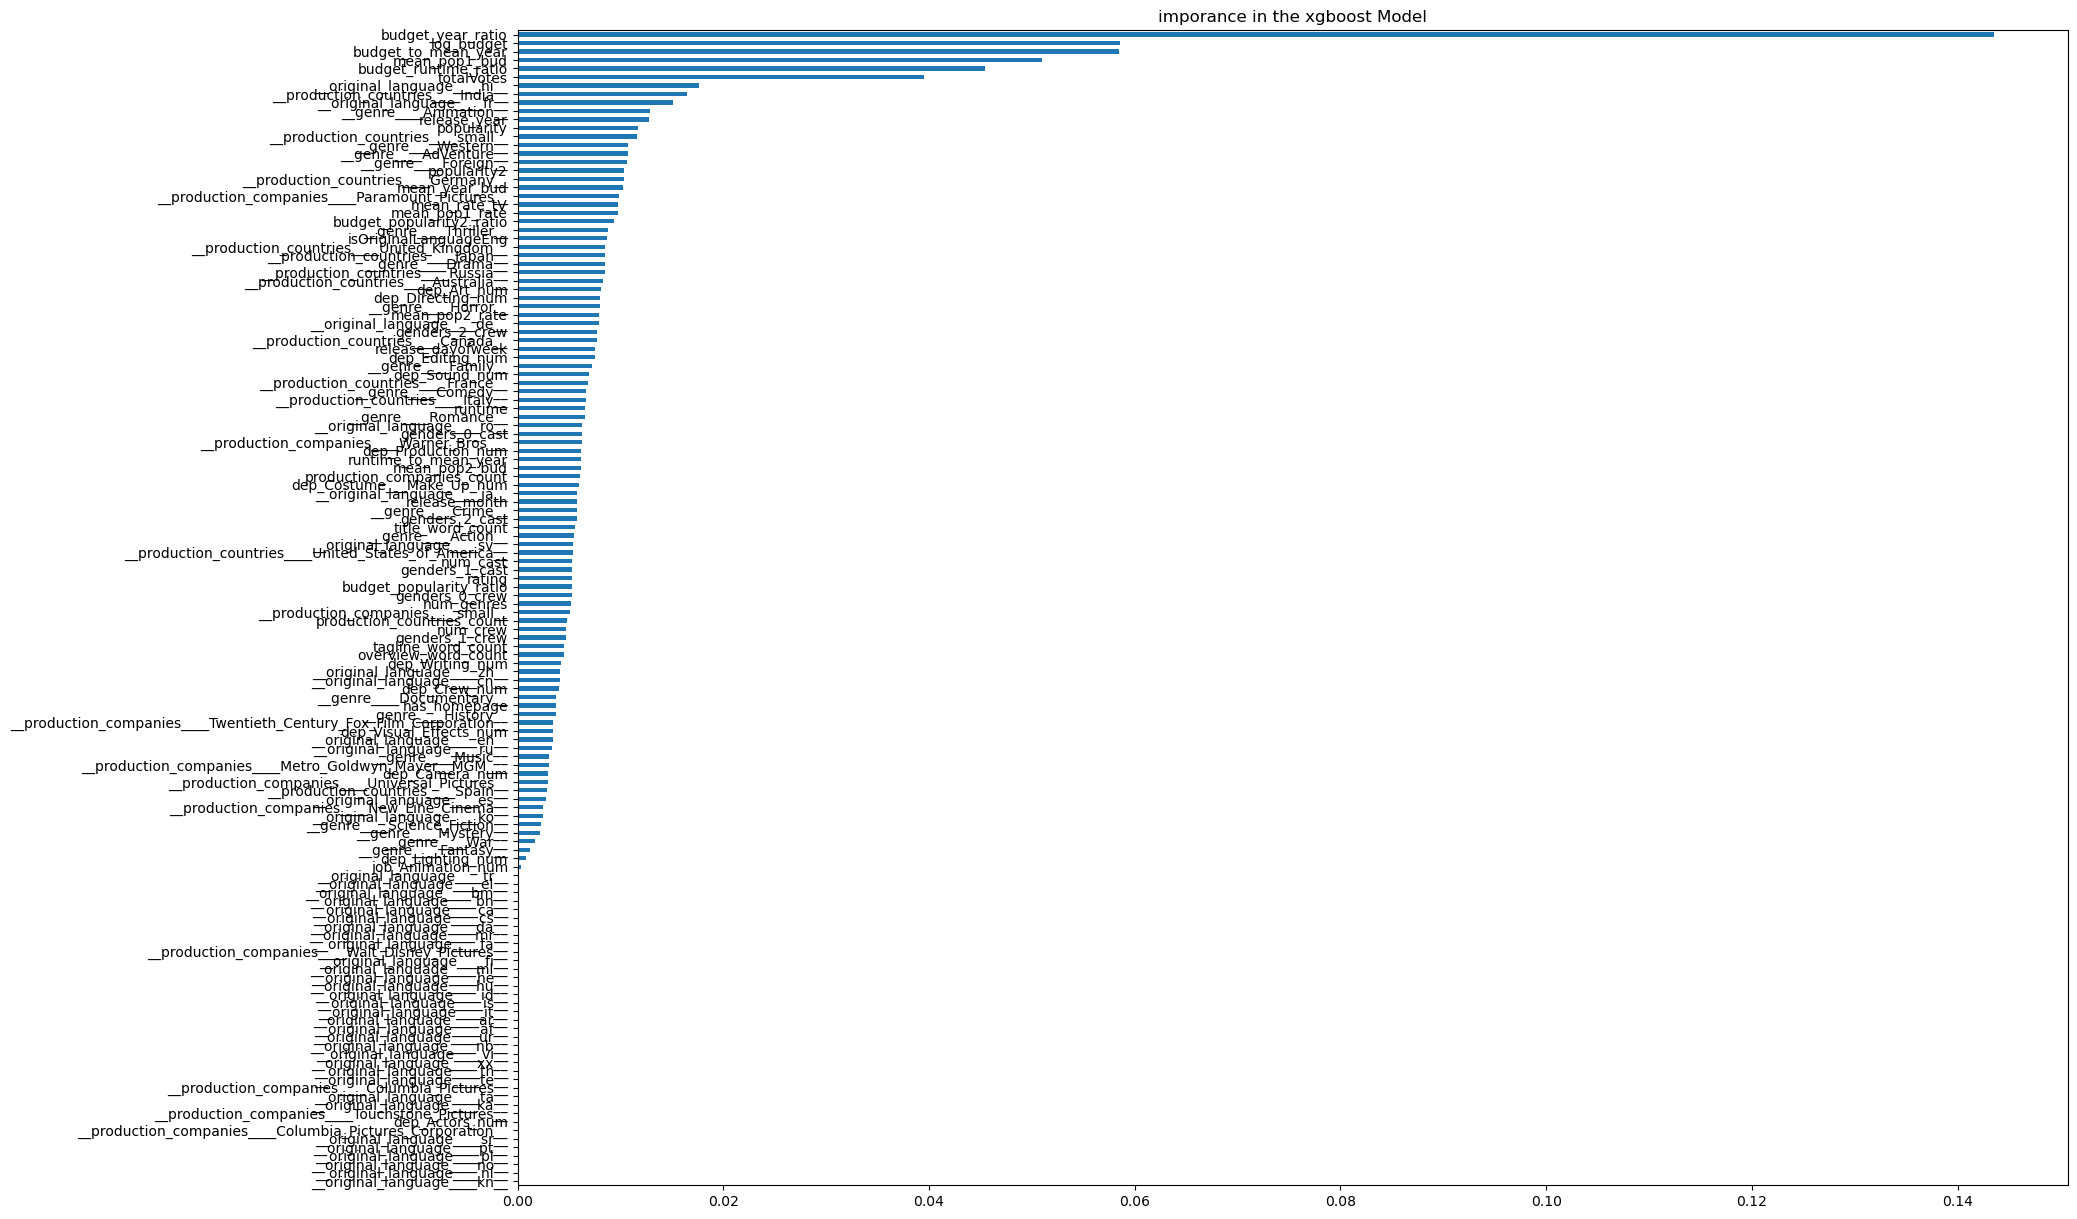

In [92]:
plt.figure(figsize=(20,15))
importances = pd.Series(xgbmodel.feature_importances_, index = df_use.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()